In [2]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, accuracy_score
from sklearn.calibration import calibration_curve
from imblearn.over_sampling import SMOTE  # For handling class imbalance


In [3]:
# Read the dataset
df = pd.read_csv("ElectricVehicle.csv")

# This will Verify that the dataset is loaded correctly 
print("Dataset Overview:")
print(df.head())
print("\nDataset Info:")
print(df.info())

Dataset Overview:
   VIN (1-10)    County       City State  Postal Code  Model Year        Make  \
0  1N4AZ0CP8D      King  Shoreline    WA      98177.0        2013      NISSAN   
1  5YJSA1E45K      King    Seattle    WA      98112.0        2019       TESLA   
2  WVGUNPE28M    Kitsap     Olalla    WA      98359.0        2021  VOLKSWAGEN   
3  JTDKARFP6H  Thurston    Olympia    WA      98501.0        2017      TOYOTA   
4  1FADP5CU9G  Thurston    Olympia    WA      98506.0        2016        FORD   

         Model                   Electric Vehicle Type  \
0         LEAF          Battery Electric Vehicle (BEV)   
1      MODEL S          Battery Electric Vehicle (BEV)   
2         ID.4          Battery Electric Vehicle (BEV)   
3  PRIUS PRIME  Plug-in Hybrid Electric Vehicle (PHEV)   
4        C-MAX  Plug-in Hybrid Electric Vehicle (PHEV)   

                      Clean Alternative Fuel Vehicle  Electric Range  \
0            Clean Alternative Fuel Vehicle Eligible            75.0   
1 


Class Distribution:
Clean Alternative Fuel Vehicle
Eligibility unknown as battery range has not been researched    124101
Clean Alternative Fuel Vehicle Eligible                          70826
Not eligible due to low battery range                            21826
Name: count, dtype: int64

Class Distribution (Percentage):
Clean Alternative Fuel Vehicle
Eligibility unknown as battery range has not been researched    57.254571
Clean Alternative Fuel Vehicle Eligible                         32.675903
Not eligible due to low battery range                           10.069526
Name: proportion, dtype: float64


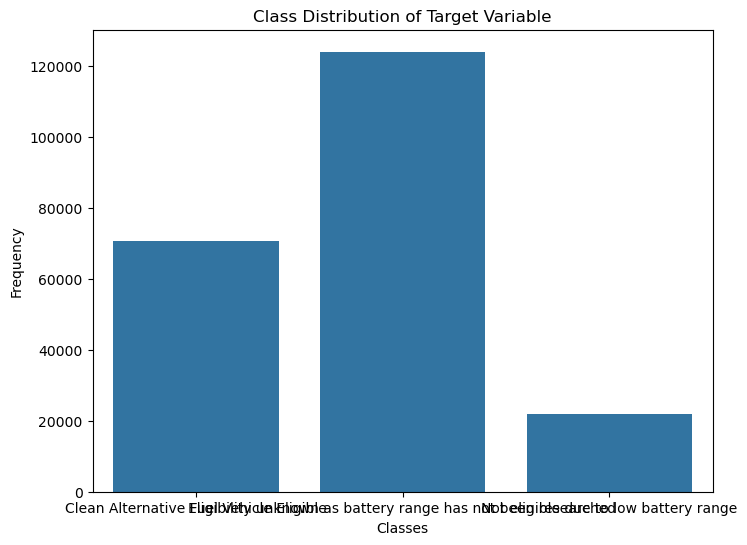

In [4]:
# Selecting the features and target variable
target = 'Clean Alternative Fuel Vehicle'
features = ['Model Year', 'Electric Range', 'Base MSRP', 'State', 'Make']

# Handle missing values by dropping the rows
df.dropna(subset=features + [target], inplace=True)

# Checking for the class imbalance 
print("\nClass Distribution:")
print(df[target].value_counts())

print("\nClass Distribution (Percentage):")
print(df[target].value_counts(normalize=True) * 100)

# Visual Graph for the  class imbalance
plt.figure(figsize=(8, 6))
sns.countplot(x=target, data=df)
plt.title("Class Distribution of Target Variable")
plt.xlabel("Classes")
plt.ylabel("Frequency")
plt.show()


In [5]:
# Encode categorical variable
encoder = LabelEncoder()
df['State'] = encoder.fit_transform(df['State'])
df['Make'] = encoder.fit_transform(df['Make'])
df[target] = encoder.fit_transform(df[target])


In [7]:
# Split the dataset into training and test set 80/20
X = df[features]  
y = df[target]  

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Handling the  class imbalance using SMOTE
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Standardise features makes the values of each feature in the data have zero-mean
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_resampled)
X_test_scaled = scaler.transform(X_test)



In [11]:
# Training the model with class weights
lr_model = LogisticRegression(max_iter=1000, random_state=42, class_weight='balanced')
lr_model.fit(X_train_scaled, y_train_resampled)


LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)


Model Accuracy: 100.00%

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     14152
           1       1.00      1.00      1.00     24912
           2       1.00      1.00      1.00      4287

    accuracy                           1.00     43351
   macro avg       1.00      1.00      1.00     43351
weighted avg       1.00      1.00      1.00     43351



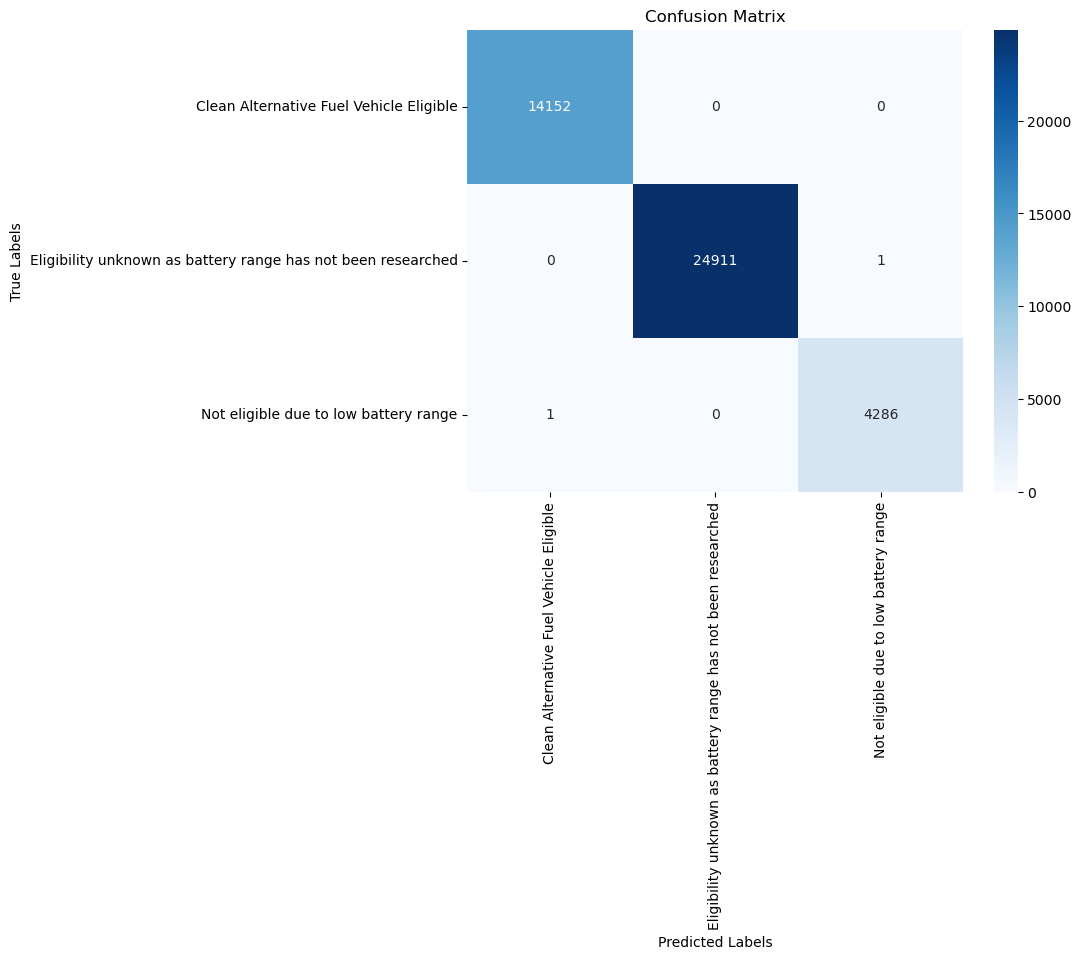

In [12]:
# Make the predictions and evaluate them
y_pred = lr_model.predict(X_test_scaled)

accuracy = accuracy_score(y_test, y_pred)
print(f"\nModel Accuracy: {accuracy * 100:.2f}%")

#Displaying Classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Graph for Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=encoder.inverse_transform(range(len(cm))), 
            yticklabels=encoder.inverse_transform(range(len(cm))))
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()


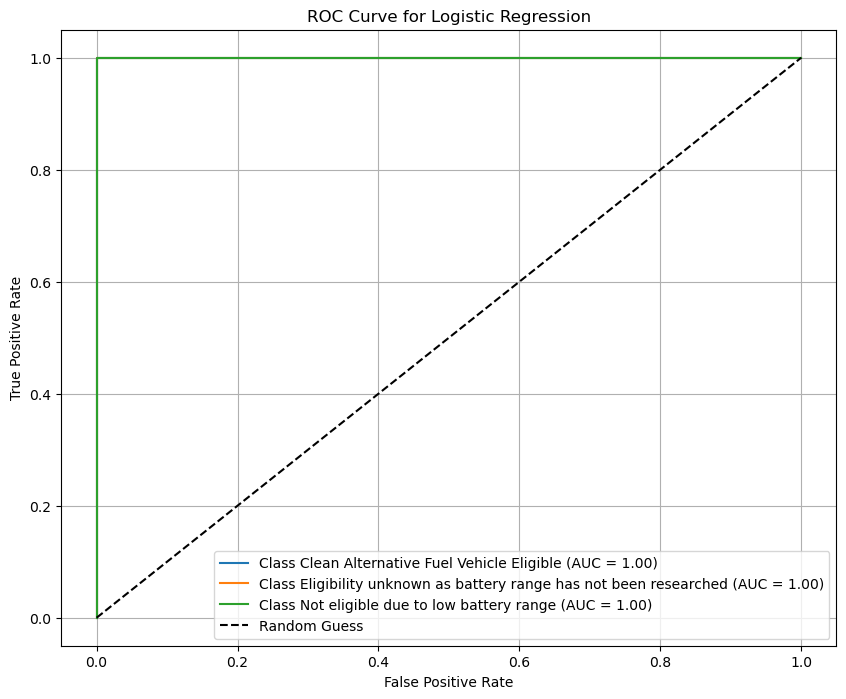

In [13]:
# Graphs for the ROC Curve and AUC
y_prob = lr_model.predict_proba(X_test_scaled)
n_classes = len(encoder.classes_)

plt.figure(figsize=(10, 8))
for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_test == i, y_prob[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"Class {encoder.inverse_transform([i])[0]} (AUC = {roc_auc:.2f})")

plt.plot([0, 1], [0, 1], 'k--', label="Random Guess")
plt.title("ROC Curve for Logistic Regression")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.grid()
plt.show()


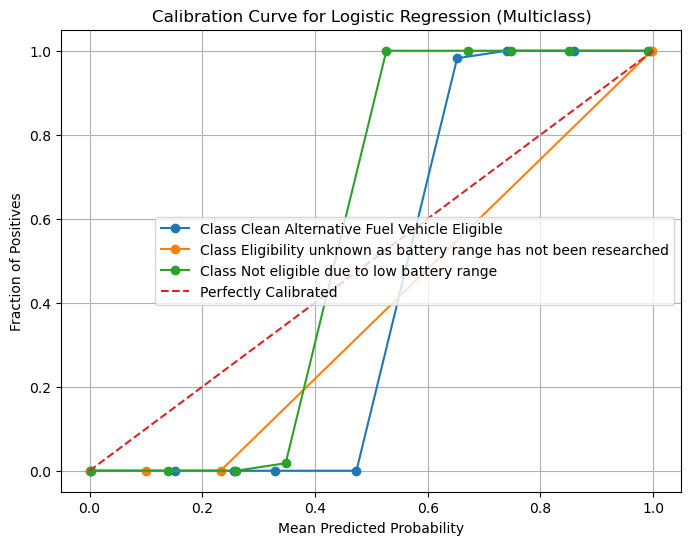

In [14]:
# Graph for the Calibration Curve
plt.figure(figsize=(8, 6))

# Looping through each class to retrieve their prediction
for i in range(n_classes):
    prob_pos = lr_model.predict_proba(X_test_scaled)[:, i]
    fraction_of_positives, mean_predicted_value = calibration_curve(y_test == i, prob_pos, n_bins=10)
    plt.plot(mean_predicted_value, fraction_of_positives, marker='o', label=f'Class {encoder.inverse_transform([i])[0]}')

# Perfectly Calibrated Line to compare
plt.plot([0, 1], [0, 1], linestyle='--', label='Perfectly Calibrated')

plt.title("Calibration Curve for Logistic Regression (Multiclass)")
plt.xlabel("Mean Predicted Probability")
plt.ylabel("Fraction of Positives")
plt.legend()
plt.grid(True)
plt.show()
